In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
import torch.nn as nn
from torch import optim
from defake.config import device
from defake.models.models import DnCNN, SiameseNetwork, SimpleNet

print(device)


/Users/gigi/opt/anaconda3/envs/diffusers_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
class DatasetTrial(Dataset):

    def __init__(self, dataset): # dataset: list[list[np.array]]
        """
        dataset: list[list[np.array]]
        dataset is a list containing num_class elements
         - each element is a list containing n_samples_per_class elements
         --- each element is a np.ndarray of shape (3, H, W) in the range [0..1]
        """
        self.dataset = dataset
        self.num_classes = len(self.dataset)
        
    def __len__(self):
        return len(self.dataset[0])

    def __getitem__(self, idx):
        """
        return a list of n_class elements
        - each element is a np.ndarray of shape (3, H, W)
        """
        return [self.dataset[class_][idx] for class_ in range(self.num_classes)]

def create_uniform_rgb(r,g,b, width = 128,height = 128):
    r_matrix = np.full((height,width), r, dtype=np.float32)
    g_matrix = np.full((height,width), g, dtype=np.float32)
    b_matrix = np.full((height,width), b, dtype=np.float32)
    # r_matrix[height-5:height-1,width-5:width-1] = 255
    # g_matrix[height-5:height-1,width-5:width-1] = 255
    # b_matrix[height-5:height-1,width-5:width-1] = 255
    return np.asanyarray([r_matrix,g_matrix,b_matrix]) # shape: (channels, height, width)

def generate_random_with_min(min=.5):
  random_number = random.random()
  return (random_number+min)/(1.+min)


class PatchDataset(Dataset):

    def __init__(self, dataset): # dataset: list[list[np.array]]
        """
        dataset: list[list[np.array]]
        dataset is a list containing num_class elements
         - each element is a list containing n_samples_per_class elements
         --- each element is a np.ndarray of shape (3, H, W) in the range [0..1]
        """
        self.dataset = dataset
        self.num_classes = len(self.dataset)
        
    def __len__(self):
        return len(self.dataset[0])

    def __getitem__(self, idx):
        """
        return a list of n_class elements
        - each element is a np.ndarray of shape (3, H, W)
        """
        return [self.dataset[class_][idx] for class_ in range(self.num_classes)]


class DBL_loss():
  """Distance Based Loss
  Do not work. Use the function compute_DBL_loss instead.
  """
  def __init__(self, batch_size, device):

    # building the correspondance matrix
    self.correspondence_matrix = torch.zeros(batch_size, batch_size, dtype=torch.bool, device=device) # N x N matrix (L in the paper)
    for idx_class in range(n_classes):
      self.correspondence_matrix[idx_class*batch_size_per_class:(idx_class+1)*batch_size_per_class, idx_class*batch_size_per_class:(idx_class+1)*batch_size_per_class] = True

  def compute_loss(self, batch_outputs):
    # distance matrix
    output_vectors = torch.flatten(batch_outputs.squeeze(), start_dim=1, end_dim=2) # Shape (N, 128*128)
    distance_matrix = torch.cdist(output_vectors, output_vectors, p=2.) # Shape (N, N)

    # Computing softmax for each row of distance matrix - Equation (1)
    # Probability matrix
    P = nn.functional.softmax(-distance_matrix, dim=1) # TODO: The element on the distance_matrix should be setted to -inf to be not considered in the softmax
    
    # Equation (2)
    L = -torch.log((P * self.correspondence_matrix).sum(dim=1))

    # Equation (3)
    loss = torch.sum(L)

    return loss


def compute_DBL_loss(batch_outputs, correspondence_matrix):
  """
  batch_outputs: shape (N, 1, H, W)
  correspondence_matrix: shape (N x N)
  """
  # distance matrix
  output_vectors = torch.flatten(batch_outputs.squeeze(), start_dim=1, end_dim=2) # Shape (N, H*W)
  distance_matrix = torch.cdist(output_vectors, output_vectors, p=2.) # Shape (N, N)

  # Computing softmax for each row of distance matrix - Equation (1)
  # Probability matrix
  P = nn.functional.softmax(-distance_matrix, dim=1) # TODO: The element on the distance_matrix should be setted to -inf to be not considered in the softmax
  
  # Equation (2)
  L = -torch.log((P * correspondence_matrix).sum(dim=1))

  # Equation (3)
  loss = torch.sum(L)

  return loss

In [3]:
n_samples_per_class_train = 500 # also called n
n_samples_per_class_val = 200
n_samples_per_class_test = 100
batch_size = 9 # also called N

dataset_train_blue = [create_uniform_rgb(0,0, generate_random_with_min()) for _ in range(n_samples_per_class_train)]
dataset_train_red = [create_uniform_rgb(generate_random_with_min(), 0, 0) for _ in range(n_samples_per_class_train)]
dataset_train_green = [create_uniform_rgb(0, generate_random_with_min(), 0) for _ in range(n_samples_per_class_train)]
dataset_val_blue = [create_uniform_rgb(0,0, generate_random_with_min()) for _ in range(n_samples_per_class_val)]
dataset_val_red = [create_uniform_rgb(generate_random_with_min(), 0, 0) for _ in range(n_samples_per_class_val)]
dataset_val_green = [create_uniform_rgb(0, generate_random_with_min(), 0) for _ in range(n_samples_per_class_val)]
dataset_test_blue = [create_uniform_rgb(0,0, generate_random_with_min()) for _ in range(n_samples_per_class_test)]
dataset_test_red = [create_uniform_rgb(generate_random_with_min(), 0, 0) for _ in range(n_samples_per_class_test)]
dataset_test_green = [create_uniform_rgb(0, generate_random_with_min(), 0) for _ in range(n_samples_per_class_test)]
dataset_train_list = [dataset_train_red, dataset_train_green, dataset_train_blue] # list of 3 elements -> list of images_per_classes elements -> each image has shape (3, 128, 128)
dataset_val_list = [dataset_val_red, dataset_val_green, dataset_val_blue]
dataset_test_list = [dataset_test_red, dataset_test_green, dataset_test_blue]

dataset_train = DatasetTrial(dataset_train_list)
dataset_val = DatasetTrial(dataset_val_list)
dataset_test = DatasetTrial(dataset_test_list)
n_classes = dataset_train.num_classes

assert (batch_size/n_classes).is_integer()

batch_size_per_class = batch_size//n_classes
dataloader_train = DataLoader(dataset_train, batch_size=batch_size_per_class, shuffle=True, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size_per_class, shuffle=True, drop_last=True)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=True, drop_last=True)


model = DnCNN(in_nc=3) # This model is really huge -> the training gonna be slow
model = SimpleNet(device)
siamese_net = SiameseNetwork(model, device)
optimizer = optim.Adam(model.parameters(), lr = 0.0005)
loss = DBL_loss(batch_size, device)

Epoch: 0 - train_loss: 9.888 - val_loss: 9.888
Epoch: 4 - train_loss: 9.888 - val_loss: 9.888
Epoch: 8 - train_loss: 9.888 - val_loss: 9.888
Epoch: 12 - train_loss: 9.888 - val_loss: 9.888
Epoch: 16 - train_loss: 9.888 - val_loss: 9.888


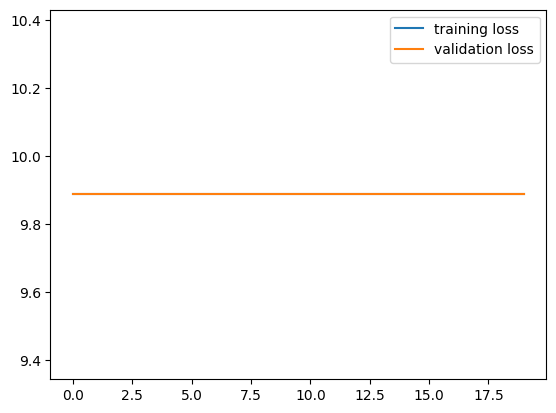

In [4]:
# N: batch size
# N = n_images_per_class * n_classes

epochs = 20

train_loss_history = [] 
train_loss_batches = []
val_loss_batches = []
val_loss_history = []


# building the correspondance matrix
correspondence_matrix = torch.zeros(batch_size, batch_size, dtype=torch.bool, device=device) # N x N matrix (L in the paper)
for idx_class in range(n_classes):
  correspondence_matrix[idx_class*batch_size_per_class:(idx_class+1)*batch_size_per_class, idx_class*batch_size_per_class:(idx_class+1)*batch_size_per_class] = True

# Iterate throught the epochs
for epoch in range(epochs):
    train_loss_batches = []
    val_loss_batches = []

    model.train()
    # Training loop
    for dataloader_item in dataloader_train:
        # dataloader_item: list of n_class elements containing tensor of shape (n, H, W)

        optimizer.zero_grad()

        # forward pass
        batch_outputs = model.compute_batch_output(dataloader_item)

        # batch_loss = loss.compute_loss(batch_outputs)
        batch_loss = compute_DBL_loss(batch_outputs, correspondence_matrix)

        batch_loss.backward()
        optimizer.step()

        train_loss_batches.append(batch_loss.item())

    model.eval()
    # Validation loop  
    for dataloader_item in dataloader_val:
        batch_outputs = model.compute_batch_output(dataloader_item)
        batch_loss = compute_DBL_loss(batch_outputs, correspondence_matrix)
        val_loss_batches.append(batch_loss.item())

    # update the training history 
    train_loss_epoch = sum(train_loss_batches) / len(train_loss_batches)
    val_loss_epoch = sum(val_loss_batches) / len(val_loss_batches)
    train_loss_history.append(train_loss_epoch)
    val_loss_history.append(val_loss_epoch)

    if epoch%4 == 0:
        print(f'Epoch: {epoch} - train_loss: {train_loss_epoch:.3f} - val_loss: {val_loss_epoch:.3f}') 

plt.plot(train_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()

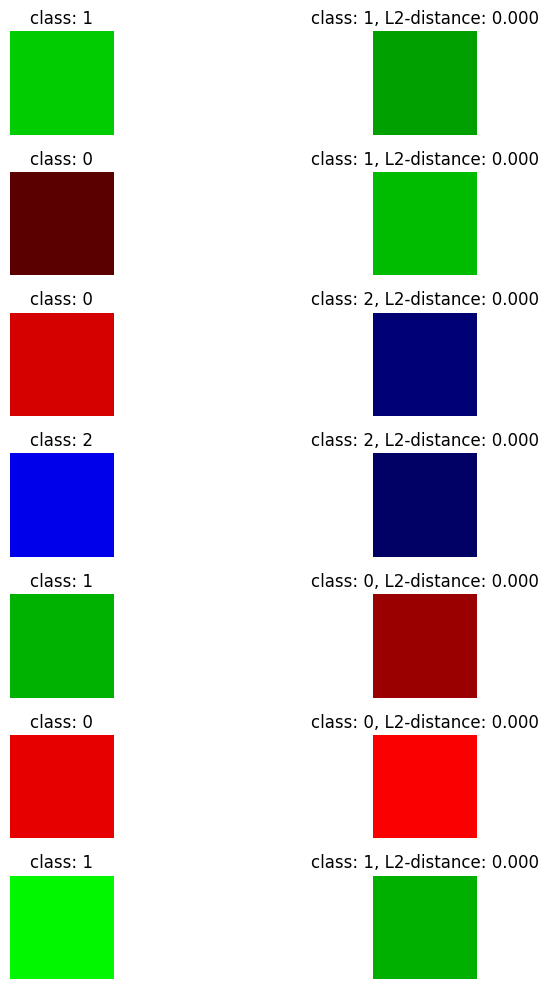

In [5]:
""" Script to show the distances of two random images output of the siamese network """

n_examples_test = 7

siamese_net.eval()

fig, axs = plt.subplots(n_examples_test, 2, figsize=(10, 10))
dataiter = iter(dataloader_test)

for i in range(n_examples_test):
  class_img_1 = random.randrange(n_classes)
  class_img_2 = random.randrange(n_classes)
  img_1 = next(dataiter)[class_img_1][0].to(device)
  img_2 = next(dataiter)[class_img_2][0].to(device)
  dist = siamese_net(img_1, img_2).item()

  axs[i, 0].imshow(np.transpose(img_1.cpu(), (1, 2, 0)))
  axs[i, 1].imshow(np.transpose(img_2.cpu(), (1, 2, 0)))
  axs[i, 0].set_title(f'class: {class_img_1}')
  axs[i, 1].set_title(f'class: {class_img_2}, L2-distance: {dist:.3f}')
  axs[i, 0].axis('off')
  axs[i, 1].axis('off')

plt.tight_layout()

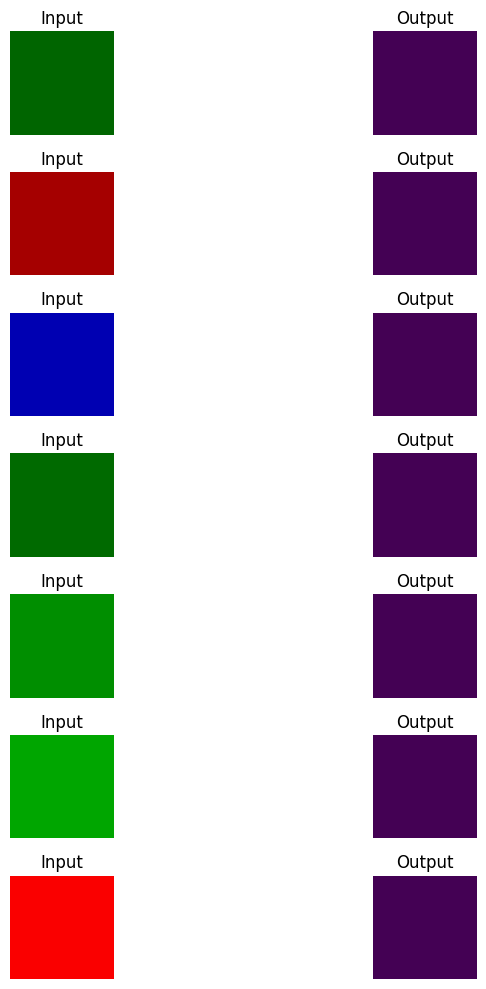

In [6]:
""" Script to show the input and output pair of the model """

n_examples_test = 7

model.eval()

fig, axs = plt.subplots(n_examples_test, 2, figsize=(10, 10))
dataiter = iter(dataloader_test)

for i in range(n_examples_test):
  class_img = random.randrange(n_classes)
  input_img = next(dataiter)[class_img].to(device)
  output_img = model(input_img).squeeze().detach()
  input_img = input_img.squeeze()

  axs[i, 0].imshow(np.transpose(input_img.cpu(), (1, 2, 0)))
  axs[i, 1].imshow(np.transpose(output_img.cpu()))
  axs[i, 0].set_title(f'Input')
  axs[i, 1].set_title(f'Output')
  axs[i, 0].axis('off')
  axs[i, 1].axis('off')
plt.tight_layout()

